In [1]:
import floris.tools as wfct
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle
import floris.tools.cc_blade_utilities as ccb
from ccblade import CCAirfoil, CCBlade
import floris.tools.sowfa_utilities as sowfa_utilities
# Some useful constants
degRad = np.pi/180.
rpmRadSec = 2.0*(np.pi)/60.0

/home/marucs/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# Load the sowfa case for an example turbine input file for the NREL 5MW
sowfa_case = sowfa_utilities.SowfaInterface('sowfa_comparisons/sowfa_example')

floris.tools.sowfa_utilities.SowfaInterface INFO sowfa_comparisons/sowfa_example
floris.tools.sowfa_utilities.SowfaInterface INFO No preprocess file found


In [3]:
# Grab the turbine dict in order to have controller values
turbine_dict = wfct.sowfa_utilities.read_foam_file(os.path.join(sowfa_case.case_folder, sowfa_case.turbine_sub_path, sowfa_case.turbine_name))

In [5]:
# Select an R and rating to test
# Get a scaled version to 40m R, 2MW
turbine_dict_base, rotor_base = ccb.scale_controller_and_rotor(turbine_dict)
turbine_dict_scaled_2mw, rotor_scaled_2mw = ccb.scale_controller_and_rotor(turbine_dict,40,2)

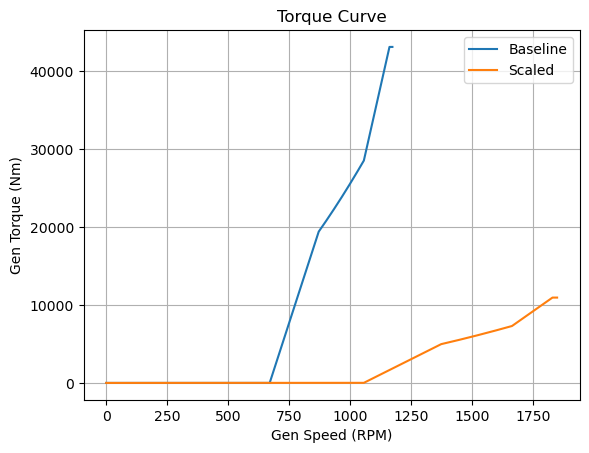

In [6]:
# Compare the torque curves
fig, ax = plt.subplots()
ccb.show_torque_curve(turbine_dict_base,ax,label='Baseline')
ccb.show_torque_curve(turbine_dict_scaled_2mw,ax,label='Scaled')

In [7]:
# Generate the baseline lut
# if it doesn't yet exist
if not os.path.exists('cp_ct_cq_lut.p'):
    ccb.generate_base_lut(rotor_base, turbine_dict_base)

Re Run Baseline
Re Run Baseline


(999805.5808270877, 0.4692325462074739, 0.7725488915451643)

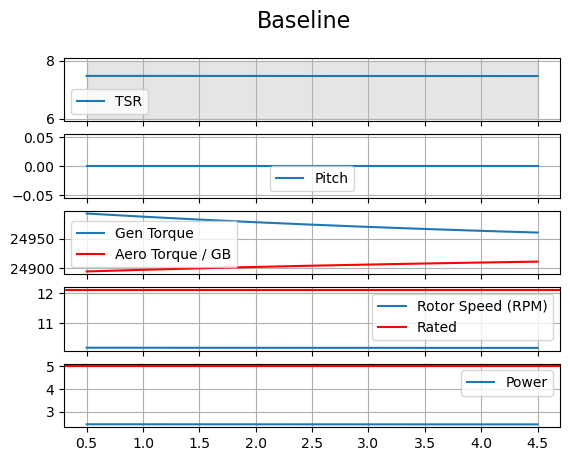

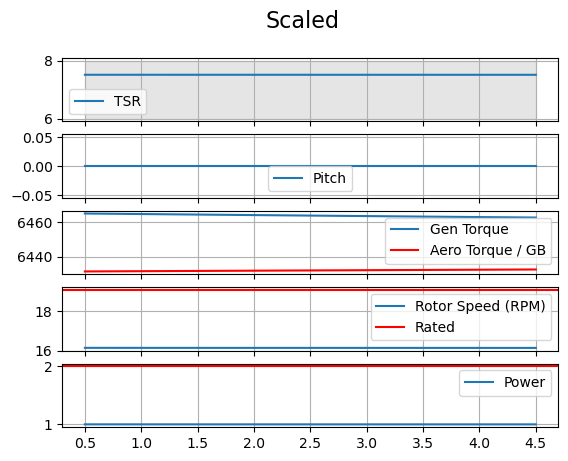

In [8]:
# Check the steady solutions at 9 m/s
ws = 9.
ccb.get_steady_state(turbine_dict_base,rotor_base,ws,title='Baseline',show_plot=True)
ccb.get_steady_state(turbine_dict_scaled_2mw,rotor_scaled_2mw,ws,title='Scaled',show_plot=True)

In [9]:
# Now get the full curves
ws_array = np.arange(5,25,2.)
ws_array, pow_array_base, cp_array_base,ct_array_base = ccb.get_wind_sweep_steady_values(turbine_dict_base,rotor_base,ws_array=ws_array)
ws_array, pow_array_scaled, cp_array_scaled,ct_array_scaled = ccb.get_wind_sweep_steady_values(turbine_dict_scaled_2mw,rotor_scaled_2mw,ws_array=ws_array)

5.0
Re Run None
Re Run None
7.0
9.0
Re Run None
Re Run None
11.0
Re Run None
Re Run None
13.0
15.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
17.0
Re Run None
19.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
21.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
23.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
5.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
7.0
Re Run None
9.0
11.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
13.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
15.0
Re Run None
17.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None
19.0
Re Run None
Re Run None
21.0
Re Run None
Re Run None
23.0
Re Run None
Re Run None
Re Run None
Re Run None
Re Run None


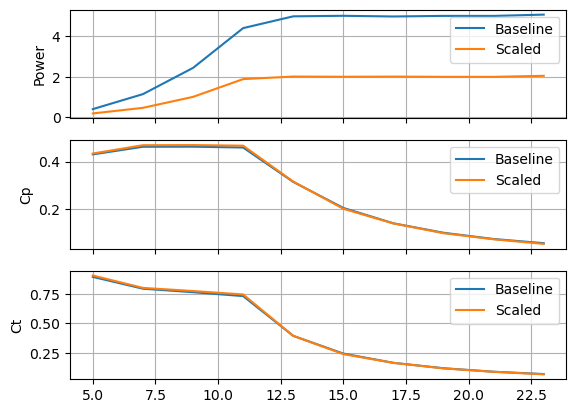

In [12]:
# Show these curvess
fig, axarr = plt.subplots(3,1,sharex=True)

ax = axarr[0]
ax.plot(ws_array, pow_array_base/1E6, label='Baseline')
ax.plot(ws_array, pow_array_scaled/1E6, label='Scaled')
ax.set_ylabel('Power')
ax.grid(True)
ax.legend()

ax = axarr[1]
ax.plot(ws_array, cp_array_base, label='Baseline')
ax.plot(ws_array, cp_array_scaled, label='Scaled')
ax.set_ylabel('Cp')
ax.grid(True)
ax.legend()

ax = axarr[2]
ax.plot(ws_array, ct_array_base, label='Baseline')
ax.plot(ws_array, ct_array_scaled, label='Scaled')
ax.set_ylabel('Ct')
ax.grid(True)
ax.legend()
plt.show()

In [11]:
# Finally output both in a format good for setting FLORIS
print("baseline")
print(repr(ws_array))
print(repr(cp_array_base * turbine_dict_base['GenEfficiency']))
print(repr(ct_array_base))

print("scaled")
print(repr(ws_array))
print(repr(cp_array_scaled * turbine_dict_scaled_2mw['GenEfficiency']))
print(repr(ct_array_scaled))


baseline
array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.])
array([0.40605878, 0.43622267, 0.4365612 , 0.43322955, 0.29700574,
       0.19382354, 0.13287856, 0.09545392, 0.07071926, 0.05413366])
array([0.89210543, 0.79225789, 0.76261984, 0.72987175, 0.39343381,
       0.24361964, 0.16537679, 0.11970413, 0.09009926, 0.07050731])
scaled
array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.])
array([0.40944833, 0.44235965, 0.44295552, 0.44051039, 0.29835035,
       0.19053056, 0.13226505, 0.09381513, 0.0695379 , 0.05134639])
array([0.90374763, 0.79921181, 0.77254889, 0.74352834, 0.39370947,
       0.23896572, 0.16495891, 0.1182509 , 0.08931789, 0.06808389])


In [13]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

from ccblade import CCAirfoil, CCBlade

First we try with Floris inbuit package

In [14]:
# geometry
Rhub = 1.5
Rtip = 63.0

r = np.array([2.8667, 5.6000, 8.3333, 11.7500, 15.8500, 19.9500, 24.0500,
              28.1500, 32.2500, 36.3500, 40.4500, 44.5500, 48.6500, 52.7500,
              56.1667, 58.9000, 61.6333])
chord = np.array([3.542, 3.854, 4.167, 4.557, 4.652, 4.458, 4.249, 4.007, 3.748,
                  3.502, 3.256, 3.010, 2.764, 2.518, 2.313, 2.086, 1.419])
theta = np.array([13.308, 13.308, 13.308, 13.308, 11.480, 10.162, 9.011, 7.795,
                  6.544, 5.361, 4.188, 3.125, 2.319, 1.526, 0.863, 0.370, 0.106])
B = 3  # number of blades

tilt = 5.0
precone = 2.5
yaw = 0.0

nSector = 8  # azimuthal discretization

# atmosphere
rho = 1.225
mu = 1.81206e-5

# power-law wind shear profile
shearExp = 0.2
hubHt = 90.0

In [15]:
afinit = CCAirfoil.initFromAerodynFile  # just for shorthand

# load all airfoils
airfoil_types = [0]*8
airfoil_types[0] = afinit('5MW_AFFiles/Cylinder1.dat')
airfoil_types[1] = afinit('5MW_AFFiles/Cylinder2.dat')
airfoil_types[2] = afinit('5MW_AFFiles/DU40_A17.dat')
airfoil_types[3] = afinit('5MW_AFFiles/DU35_A17.dat')
airfoil_types[4] = afinit('5MW_AFFiles/DU30_A17.dat')
airfoil_types[5] = afinit('5MW_AFFiles/DU25_A17.dat')
airfoil_types[6] = afinit('5MW_AFFiles/DU21_A17.dat')
airfoil_types[7] = afinit('5MW_AFFiles/NACA64_A17.dat')

# place at appropriate radial stations
af_idx = [0, 0, 1, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7]

af = [0]*len(r)
for i in range(len(r)):
    af[i] = airfoil_types[af_idx[i]]

In [16]:
# create CCBlade object
rotor = CCBlade(r, chord, theta, af, Rhub, Rtip, B, rho, mu,
                precone, tilt, yaw, shearExp, hubHt, nSector)

In [29]:

# set conditions
Uinf = 10.0
tsr = 7.55
pitch = 0.0
Omega = Uinf * tsr / Rtip * 30.0 / pi  # convert to RPM
azimuth = 0.0

# evaluate distributed loads
loads, derivs = rotor.distributedAeroLoads(Uinf, Omega, pitch, azimuth)
Np = loads["Np"]
Tp = loads["Tp"]

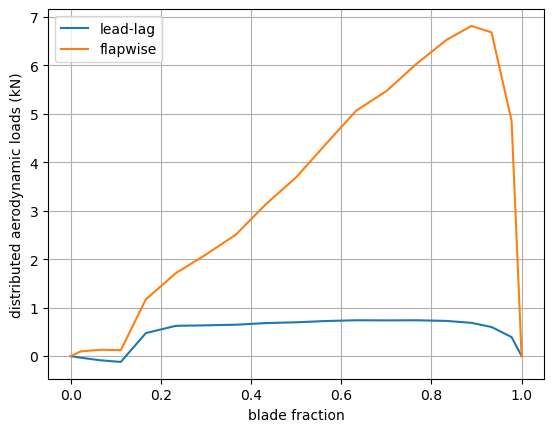

In [30]:
# plot
rstar = (r - Rhub) / (Rtip - Rhub)

# append zero at root and tip
rstar = np.concatenate([[0.0], rstar, [1.0]])
Np = np.concatenate([[0.0], Np, [0.0]])
Tp = np.concatenate([[0.0], Tp, [0.0]])


plt.plot(rstar, Tp / 1e3, label="lead-lag")
plt.plot(rstar, Np / 1e3, label="flapwise")
plt.xlabel("blade fraction")
plt.ylabel("distributed aerodynamic loads (kN)")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [19]:
outputs, derivs = rotor.evaluate([Uinf], [Omega], [pitch])

P = outputs["P"]
T = outputs["T"]
Q = outputs["Q"]

outputs, derivs = rotor.evaluate([Uinf], [Omega], [pitch], coefficients=True)

CP = outputs["CP"]
CT = outputs["CT"]
CQ = outputs["CQ"]

print("CP =", CP)
print("CT =", CT)
print("CQ =", CQ)

CP = [0.46488091]
CT = [0.76926392]
CQ = [0.06163229]


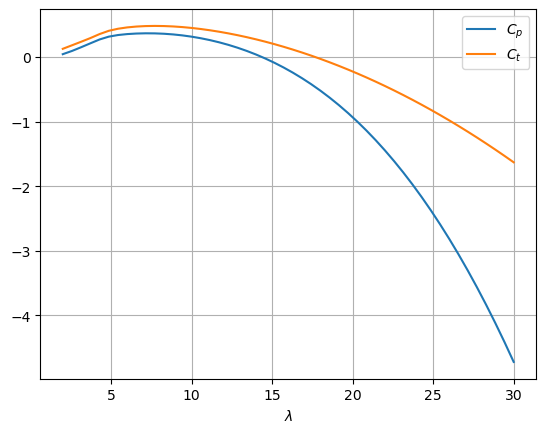

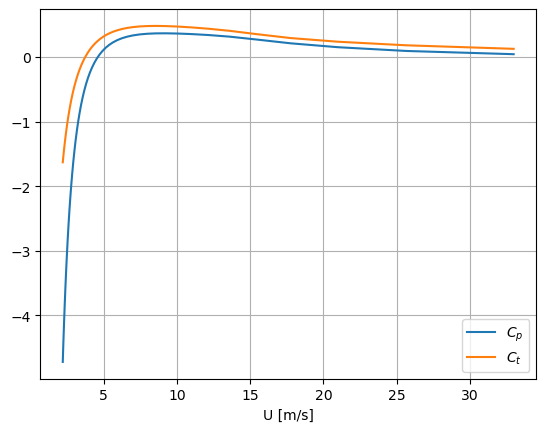

In [83]:
# velocity has a small amount of Reynolds number dependence
tsr = np.linspace(2, 30, 50)
Omega = 10.0 * np.ones_like(tsr)
Uinf = Omega * pi / 30.0 * Rtip / tsr


pitch = np.zeros_like(tsr) + 5

outputs, derivs = rotor.evaluate(Uinf, Omega, pitch, coefficients=True)

CP = outputs["CP"]
CT = outputs["CT"]
CQ = outputs["CQ"]


plt.figure()
plt.plot(tsr, CP, label="$C_p$")
plt.plot(tsr, CT, label="$C_t$")
plt.legend()
plt.xlabel("$\lambda$")
plt.grid()
plt.show()


plt.figure()
plt.plot(Uinf, CP, label="$C_p$")
plt.plot(Uinf, CT, label="$C_t$")
plt.legend()
plt.xlabel("U [m/s]")
plt.grid()
plt.show()

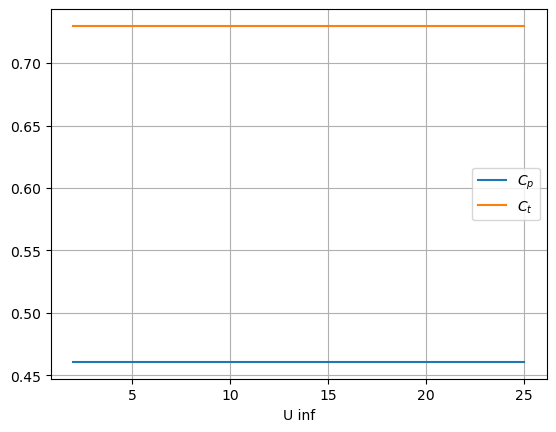

In [72]:
# velocity has a small amount of Reynolds number dependence
Uinf = np.linspace(2, 25, 50)

tsr = np.ones_like(Uinf) * 7

Omega = 10.0 * np.ones_like(tsr)
#Uinf = Omega * pi / 30.0 * Rtip / tsr
Omega = Uinf*30/pi *tsr/Rtip

pitch = np.zeros_like(tsr) 

outputs, derivs = rotor.evaluate(Uinf, Omega, pitch, coefficients=True)

CP = outputs["CP"]
CT = outputs["CT"]
CQ = outputs["CQ"]


plt.figure()
plt.plot(Uinf, CP, label="$C_p$")
plt.plot(Uinf, CT, label="$C_t$")
plt.legend()
plt.xlabel("U inf")
plt.grid()
plt.show()

In [67]:
outputs

{'P': array([-107014.91688881,  -99200.41762002,  -79692.44059628,
         -38769.50709976,   30156.44596897,  125183.647205  ,
         245298.54719777,  390080.2582304 ,  561132.00178947,
         760818.72299157,  991429.76059104, 1255032.26721756,
        1551282.08502428, 1877775.9543285 , 2232178.85182333,
        2612199.47307441, 3015143.82921597, 3436992.56025398,
        3871276.29480956, 4307886.346563  , 4732655.83043402,
        5125509.16290774, 5468579.67126523, 5760627.68504224,
        6007185.04477918, 6217525.24892572, 6406893.936708  ,
        6585718.03986569, 6758642.93191904, 6926156.13488755,
        7087882.21077524, 7242688.7198021 , 7389189.41720528,
        7525460.01989677, 7649677.2452117 , 7760670.94160313,
        7857385.09489665, 7939195.93337154, 8005580.28330883,
        8056650.10536168, 8092832.76162485, 8114703.16090412,
        8123032.07857862, 8118344.25749966, 8101211.25389723,
        8072490.967272  , 8033015.7132642 , 7983614.71652593,
   

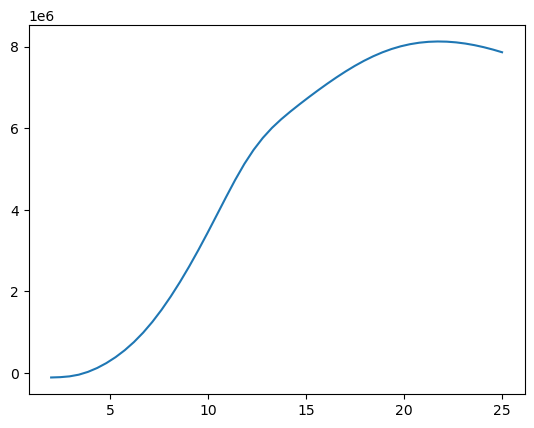

In [64]:
plt.plot(Uinf,outputs["P"])